# 11 - Ensemble Methods - Continuation


by [Alejandro Correa Bahnsen](albahnsen.com/)

version 0.2, May 2016

## Part of the class [Machine Learning for Risk Management](https://github.com/albahnsen/ML_RiskManagement)


This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Kevin Markham](https://github.com/justmarkham)

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

# Part 1: Combination of classifiers - Majority Voting

  The most typical form of an ensemble is made by combining $T$ different base classifiers.
  Each  base classifier $M(\mathcal{S}_j)$ is trained by applying algorithm $M$ to a random subset 
  $\mathcal{S}_j$ of the training set $\mathcal{S}$.  
  For simplicity we define $M_j \equiv  M(\mathcal{S}_j)$ for $j=1,\dots,T$, and 
  $\mathcal{M}=\{M_j\}_{j=1}^{T}$ a set of base classifiers.
  Then, these models are combined using majority voting to create the ensemble $H$ as follows
  $$
    f_{mv}(\mathcal{S},\mathcal{M}) = max_{c \in \{0,1\}} \sum_{j=1}^T 
    \mathbf{1}_c(M_j(\mathcal{S})).
  $$


In [1]:
# read in and prepare the chrun data
# Download the dataset
import pandas as pd
import numpy as np

data = pd.read_csv('../datasets/churn.csv')

# Create X and y

# Select only the numeric features
X = data.iloc[:, [1,2,6,7,8,9,10]].astype(np.float)
# Convert bools to floats
X = X.join((data.iloc[:, [4,5]] == 'no').astype(np.float))

y = (data.iloc[:, -1] == 'True.').astype(np.int)

In [2]:
X.head()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Int'l Plan,VMail Plan
0,128.0,415.0,25.0,265.1,110.0,45.07,197.4,1.0,0.0
1,107.0,415.0,26.0,161.6,123.0,27.47,195.5,1.0,0.0
2,137.0,415.0,0.0,243.4,114.0,41.38,121.2,1.0,1.0
3,84.0,408.0,0.0,299.4,71.0,50.90,61.9,0.0,1.0
4,75.0,415.0,0.0,166.7,113.0,28.34,148.3,0.0,1.0


In [3]:
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,2850,0.855086
1,483,0.144914


In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Create 100 decision trees

In [5]:
n_estimators = 100
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [6]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [7]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.ix[:, i] = trees[i].predict(X_test)

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
438,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1345,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,1,0
1957,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
2148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


Predict using majority voting

In [8]:
y_pred_df.sum(axis=1)[:10]

438      2
2674     5
1345    35
1957    17
2148     3
3106     4
1786    22
321      6
3082    10
2240     5
dtype: int64

In [9]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.52459016393442637

In [10]:
metrics.accuracy_score(y_pred, y_test)

0.89454545454545453

### Using majority voting with sklearn

In [11]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [12]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.53600000000000003, 0.89454545454545453)

# Part 2: Combination of classifiers - Weighted Voting

The majority voting approach gives the same weight to each classfier regardless of the performance of each one. Why not take into account the oob performance of each classifier

First, in the traditional approach, a 
similar comparison of the votes of the base classifiers is made, but giving a weight $\alpha_j$ 
to each classifier $M_j$ during the voting phase
$$
  f_{wv}(\mathcal{S},\mathcal{M}, \alpha)
  =\max_{c \in \{0,1\}} \sum_{j=1}^T \alpha_j \mathbf{1}_c(M_j(\mathcal{S})),
$$
where $\alpha=\{\alpha_j\}_{j=1}^T$.
The calculation of $\alpha_j$ is related to the performance of each classifier $M_j$.
It is usually defined as the normalized misclassification error   $\epsilon$ of the base 
classifier $M_j$  in the out of bag set   $\mathcal{S}_j^{oob}=\mathcal{S}-\mathcal{S}_j$
\begin{equation}
  \alpha_j=\frac{1-\epsilon(M_j(\mathcal{S}_j^{oob}))}{\sum_{j_1=1}^T 
  1-\epsilon(M_{j_1}(\mathcal{S}_{j_1}^{oob}))}.
\end{equation}

Select each oob sample

In [13]:
samples_oob = []
# show the "out-of-bag" observations for each sample
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

Estimate the oob error of each classifier

In [14]:
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

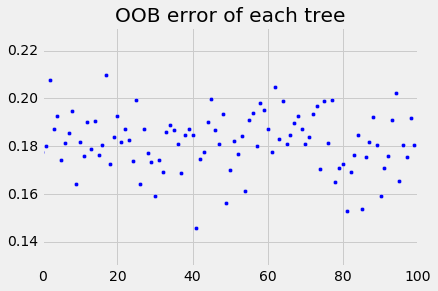

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')

Estimate $\alpha$

In [16]:
alpha = (1 - errors) / (1 - errors).sum()

In [17]:
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

In [18]:
weighted_sum_1.head(20)

438     0.019993
2674    0.050009
1345    0.350236
1957    0.170230
2148    0.030047
3106    0.040100
1786    0.219819
321     0.059707
3082    0.100178
2240    0.050128
1910    0.180194
2124    0.190111
2351    0.049877
1736    0.950014
879     0.039378
785     0.219632
2684    0.010104
787     0.710568
170     0.220390
1720    0.020166
dtype: float64

In [19]:
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.52674897119341557, 0.8954545454545455)

### Using Weighted voting with sklearn

In [20]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.53600000000000003, 0.89454545454545453)

In [21]:
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [22]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.55335968379446643, 0.89727272727272722)

# Part 3: Combination of classifiers - Stacking

The staking method consists in combining the different base classifiers by learning a 
second level algorithm on top of them. In this framework, once the base 
classifiers are constructed using the training set  $\mathcal{S}$, a new set is constructed 
where the output of the base classifiers  are now considered as the features while keeping the 
class labels.

Even though there is no restriction on which algorithm can be used as a second level learner, 
it is common to use a linear model, such as 
$$
  f_s(\mathcal{S},\mathcal{M},\beta) =
  g \left( \sum_{j=1}^T \beta_j M_j(\mathcal{S}) \right),
$$
where $\beta=\{\beta_j\}_{j=1}^T$, and $g(\cdot)$ is the sign function 
$g(z)=sign(z)$ in the case of a linear regression or the sigmoid function, defined 
as $g(z)=1/(1+e^{-z})$, in the case of a logistic regression. 

Lets first get a new training set consisting of the output of every classifier

In [23]:
X_train_2 = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    X_train_2[i] = trees[i].predict(X_train)

In [24]:
X_train_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1412,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
626,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from sklearn.linear_model import LogisticRegressionCV

In [26]:
lr = LogisticRegressionCV()
lr.fit(X_train_2, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [27]:
lr.coef_

array([[ 0.10093102,  0.1042197 ,  0.09431205,  0.09652843,  0.09709429,
         0.09902616,  0.11100235,  0.09662288,  0.09340919,  0.09112994,
         0.10012606,  0.09821902,  0.09383543,  0.09553507,  0.09147579,
         0.09649564,  0.08965686,  0.09196857,  0.09684012,  0.09020758,
         0.09839592,  0.09513808,  0.1044603 ,  0.10028703,  0.09671603,
         0.09725639,  0.10912207,  0.10590827,  0.10275491,  0.10275279,
         0.10607316,  0.09803225,  0.10319411,  0.0926599 ,  0.09702325,
         0.09524124,  0.088848  ,  0.09960894,  0.09053403,  0.09010282,
         0.0990557 ,  0.0987997 ,  0.10538386,  0.09584352,  0.09633964,
         0.09001206,  0.09181887,  0.08995095,  0.10130986,  0.10827168,
         0.10064992,  0.09771002,  0.08922346,  0.10078438,  0.10173442,
         0.1052274 ,  0.09743252,  0.09597317,  0.08932798,  0.10033609,
         0.10346122,  0.10145004,  0.09017084,  0.10348697,  0.09335995,
         0.09795824,  0.10166729,  0.09306547,  0.0

In [28]:
y_pred = lr.predict(y_pred_df)

In [29]:
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.53658536585365846, 0.89636363636363636)

### Using sklearn

In [30]:
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_3 = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):

    X_train_3[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
lr = LogisticRegressionCV()
lr.fit(X_train_3, y_train)

y_pred = lr.predict(y_pred_all_)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.56250000000000011, 0.89818181818181819)

vs using only one dt

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.44510385756676557, 0.82999999999999996)

# Part 4: Boosting

While boosting is not algorithmically constrained, most boosting algorithms consist of iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier. When they are added, they are typically weighted in some way that is usually related to the weak learners' accuracy. After a weak learner is added, the data is reweighted: examples that are misclassified gain weight and examples that are classified correctly lose weight (some boosting algorithms actually decrease the weight of repeatedly misclassified examples, e.g., boost by majority and BrownBoost). Thus, future weak learners focus more on the examples that previous weak learners misclassified. (Wikipedia)

![](images/OurMethodv81.png)

## Adaboost

AdaBoost (adaptive boosting) is an ensemble learning algorithm that can be used for classification or regression. Although AdaBoost is more resistant to overfitting than many machine learning algorithms, it is often sensitive to noisy data and outliers.

AdaBoost is called adaptive because it uses multiple iterations to generate a single composite strong learner. AdaBoost creates the strong learner (a classifier that is well-correlated to the true classifier) by iteratively adding weak learners (a classifier that is only slightly correlated to the true classifier). During each round of training, a new weak learner is added to the ensemble and a weighting vector is adjusted to focus on examples that were misclassified in previous rounds. The result is a classifier that has higher accuracy than the weak learners’ classifiers.

Algorithm:

* Initialize all weights ($w_i$) to 1 / n_samples
* Train a classifier $h_t$ using weights
* Estimate training error $e_t$
* set $alpha_t = log\left(\frac{1-e_t}{e_t}\right)$
* Update weights 
$$w_i^{t+1} = w_i^{t}e^{\left(\alpha_t \mathbf{I}\left(y_i \ne h_t(x_t)\right)\right)}$$
* Repeat while $e_t<0.5$ and $t<T$


In [33]:
# read in and prepare the chrun data
# Download the dataset
import pandas as pd
import numpy as np

data = pd.read_csv('../datasets/churn.csv')

# Create X and y

# Select only the numeric features
X = data.iloc[:, [1,2,6,7,8,9,10]].astype(np.float)
# Convert bools to floats
X = X.join((data.iloc[:, [4,5]] == 'no').astype(np.float))

y = (data.iloc[:, -1] == 'True.').astype(np.int)

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
n_samples = X_train.shape[0]

In [34]:
n_estimators = 10
weights = pd.DataFrame(index=X_train.index, columns=list(range(n_estimators)))

In [35]:
t = 0
weights[t] = 1 / n_samples

Train the classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier
trees = []
trees.append(DecisionTreeClassifier(max_depth=1))
trees[t].fit(X_train, y_train, sample_weight=weights[t].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Estimate error

In [37]:
y_pred_ = trees[t].predict(X_train)
error = []
error.append(1 - metrics.accuracy_score(y_pred_, y_train))
error[t]

0.13613972234661886

In [38]:
alpha = []
alpha.append(np.log((1 - error[t]) / error[t]))
alpha[t]

1.8477293114995077

Update weights

In [39]:
weights[t + 1] = weights[t]
filter_ = y_pred_ != y_train

In [40]:
weights.loc[filter_, t + 1] = weights.loc[filter_, t] * np.exp(alpha[t])

Normalize weights

In [41]:
weights[t + 1] = weights[t + 1] / weights[t + 1].sum()

**Iteration 2 - n_estimators**

In [42]:
for t in range(1, n_estimators):
    trees.append(DecisionTreeClassifier(max_depth=1))
    trees[t].fit(X_train, y_train, sample_weight=weights[t].values)
    y_pred_ = trees[t].predict(X_train)
    error.append(1 - metrics.accuracy_score(y_pred_, y_train))
    alpha.append(np.log((1 - error[t]) / error[t]))
    weights[t + 1] = weights[t]
    filter_ = y_pred_ != y_train
    weights.loc[filter_, t + 1] = weights.loc[filter_, t] * np.exp(alpha[t])
    weights[t + 1] = weights[t + 1] / weights[t + 1].sum()

In [43]:
error

[0.13613972234661886,
 0.15629198387819077,
 0.84370801612180923,
 0.84370801612180923,
 0.84370801612180923,
 0.84370801612180923,
 0.84370801612180923,
 0.84370801612180923,
 0.84370801612180923,
 0.84370801612180923]

### Create classification

Only classifiers when error < 0.5

In [44]:
new_n_estimators = np.sum([x<0.5 for x in error])

In [45]:
y_pred_all = np.zeros((X_test.shape[0], new_n_estimators))
for t in range(new_n_estimators):
    y_pred_all[:, t] = trees[t].predict(X_test)

In [46]:
y_pred = (np.sum(y_pred_all * alpha[:new_n_estimators], axis=1) >= 1).astype(np.int)

In [47]:
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.51051051051051044, 0.85181818181818181)

### Using sklearn

In [48]:
from sklearn.ensemble import AdaBoostClassifier

In [49]:
clf = AdaBoostClassifier()
clf

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [50]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.29107981220657275, 0.86272727272727268)

### Gradient Boosting

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test.values), metrics.accuracy_score(y_pred, y_test.values)

(0.52892561983471076, 0.89636363636363636)